## Inductive and Deductive Inference to Understand Autoantibody–Proteomic Interactions in SLE Using Knowledge Graphs

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split



In [149]:
# read data
aca_data = pd.read_csv('data/aca_data.csv')
proteomic_data = pd.read_csv('data/proteomic_data.csv')
proteomic_module_data = pd.read_csv('data/proteomic_module_data.csv')
sledai_data = pd.read_csv('data/sledai_data.csv')

In [150]:
# rename person_id column to PMBBID in all dataframes
aca_data.rename(columns={'person_id': 'PMBBID'}, inplace=True)
proteomic_data.rename(columns={'person_id': 'PMBBID'}, inplace=True)
proteomic_module_data.rename(columns={'person_id': 'PMBBID'}, inplace=True)
sledai_data.rename(columns={'person_id': 'PMBBID'}, inplace=True)

### Inductive Classifier

In [151]:
# merge data
merged_data = aca_data.merge(proteomic_module_data, on='PMBBID')
merged_data = merged_data.merge(sledai_data, on='PMBBID')
# binarize SLEDAI column: 1 if SLEDAI >= 4 else 0  - this represents active vs inactive disease
merged_data['SLEDAI_binarized'] = merged_data['SLEDAI'].apply(lambda x: 1 if x >= 4 else 0)

In [152]:
# features of interest
module_cols = [c for c in merged_data.columns if c.startswith("ME")]
aca_cols = ['ACA.IFNALPHA',
    'ACA.IL15',
    'ACA.IL31',
    'ACA.LIF',
    'ACA.MIP',
    'ACA.IFNTWOLAMDA',
    'ACA.GMCSF',
    'ACA.IFNEPSILON',
    'ACA.TNFBETA',
    'ACA.IL22',
    'ACA.CT',
    'ACA.IL6',
    'ACA.IL11',
    'ACA.IL1ALPHA',
    'ACA.SRANK',
    'ACA.IL17A',
    'ACA.IL33',
    'ACA.IL7',
    'ACA.IL17F',
    'ACA.OSM',
    'ACA.TNFALPHA',
    'ACA.PDGFBB',
    'ACA.VEGFB',
    'ACA.IFNONELAMDA',
    'ACA.IL1BETA',
    'ACA.IL10',
    'ACA.IFNGAMMA',
    'ACA.IL12',
    'ACA.CCL11',
    'ACA.CCL24',
    'ACA.TRIM33',
    'ACA.IL27',
    'ACA.CNTF',
    'ACA.CD74',
    'ACA.IFNBETA',
    'ACA.IFNTHREELAMDA',
    'ACA.ACE2',
    'ACA.IL12P40',
    'ACA.IFNOMEGA']
input_features = module_cols + ['age'] + aca_cols 
target_variable = 'SLEDAI_binarized'

In [153]:
data_model = merged_data[['PMBBID'] + input_features + [target_variable]]

In [154]:
# train test split
train_data, test_data = train_test_split(data_model, test_size=0.2, random_state=42)

X_train = train_data[input_features]
y_train = train_data[target_variable]

X_test = test_data[input_features]
y_test = test_data[target_variable]

In [155]:
# show relative class dist in testing data
y_test.value_counts()

SLEDAI_binarized
0    20
1    16
Name: count, dtype: int64

In [156]:
# train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
rf_classifier = RandomForestClassifier(n_estimators=5, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# print accuracy
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.2f}')

# print F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1:.2f}')

# print AUC
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc_score:.2f}')

Accuracy: 0.72
F1-score: 0.64
AUC: 0.71


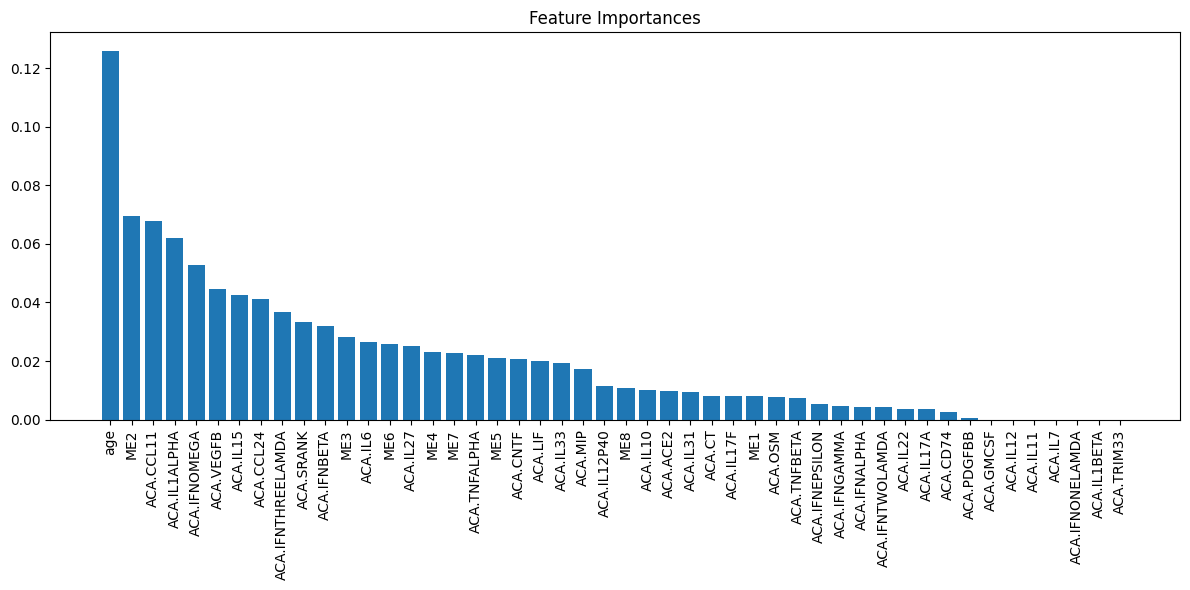

In [173]:
# show plot of feature importances
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [input_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

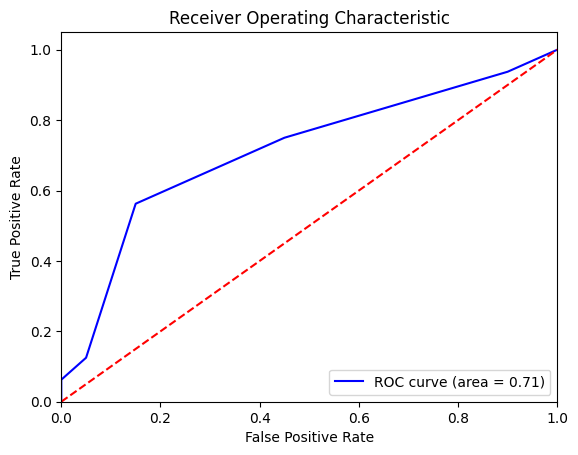

In [174]:
# plot AUC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Deductive Classifier

In [157]:
# add .binarized to aca column names
aca_cols = [col + '.binarized' for col in aca_cols]
print(f"Module columns: {module_cols}")
print(f"ACA columns: {aca_cols}")
discretized_data = merged_data.copy()
# filter to PMBBIDs in train_data
discretized_data_train = discretized_data[discretized_data['PMBBID'].isin(train_data['PMBBID'])]
discretized_data_test = discretized_data[discretized_data['PMBBID'].isin(test_data['PMBBID'])]

Module columns: ['ME1', 'ME2', 'ME3', 'ME4', 'ME5', 'ME6', 'ME7', 'ME8']
ACA columns: ['ACA.IFNALPHA.binarized', 'ACA.IL15.binarized', 'ACA.IL31.binarized', 'ACA.LIF.binarized', 'ACA.MIP.binarized', 'ACA.IFNTWOLAMDA.binarized', 'ACA.GMCSF.binarized', 'ACA.IFNEPSILON.binarized', 'ACA.TNFBETA.binarized', 'ACA.IL22.binarized', 'ACA.CT.binarized', 'ACA.IL6.binarized', 'ACA.IL11.binarized', 'ACA.IL1ALPHA.binarized', 'ACA.SRANK.binarized', 'ACA.IL17A.binarized', 'ACA.IL33.binarized', 'ACA.IL7.binarized', 'ACA.IL17F.binarized', 'ACA.OSM.binarized', 'ACA.TNFALPHA.binarized', 'ACA.PDGFBB.binarized', 'ACA.VEGFB.binarized', 'ACA.IFNONELAMDA.binarized', 'ACA.IL1BETA.binarized', 'ACA.IL10.binarized', 'ACA.IFNGAMMA.binarized', 'ACA.IL12.binarized', 'ACA.CCL11.binarized', 'ACA.CCL24.binarized', 'ACA.TRIM33.binarized', 'ACA.IL27.binarized', 'ACA.CNTF.binarized', 'ACA.CD74.binarized', 'ACA.IFNBETA.binarized', 'ACA.IFNTHREELAMDA.binarized', 'ACA.ACE2.binarized', 'ACA.IL12P40.binarized', 'ACA.IFNOMEGA.bi

In [158]:
# discretize modules into LOW/MEDIUM/HIGH
module_cutoffs = {}
for mod in module_cols:
    quantile_low = discretized_data_train[mod].quantile(0.33)
    quantile_high = discretized_data_train[mod].quantile(0.67)
    module_cutoffs[mod] = (quantile_low, quantile_high)
    discretized_data_train[mod + "_disc"] = pd.cut(discretized_data_train[mod],
                                                  bins=[-np.inf, quantile_low, quantile_high, np.inf],
                                                  labels=[0, 1, 2])
# apply same cutoffs to test data
for mod in module_cols:
    quantile_low, quantile_high = module_cutoffs[mod]
    discretized_data_test[mod + "_disc"] = pd.cut(discretized_data_test[mod],
                                                 bins=[-np.inf, quantile_low, quantile_high, np.inf],
                                                 labels=[0, 1, 2])

/var/folders/9l/wxhth3yx1ys6c10zvrh_t0y40000gp/T/ipykernel_11299/2452078556.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discretized_data_train[mod + "_disc"] = pd.cut(discretized_data_train[mod],
/var/folders/9l/wxhth3yx1ys6c10zvrh_t0y40000gp/T/ipykernel_11299/2452078556.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discretized_data_train[mod + "_disc"] = pd.cut(discretized_data_train[mod],
/var/folders/9l/wxhth3yx1ys6c10zvrh_t0y40000gp/T/ipykernel_11299/2452078556.py:7: SettingWithCopyWarning

In [160]:
rules_aca_module = []

for aca in aca_cols:
    for mod in module_cols:
        mod_disc = mod + "_disc"

        # Data for ACA-positive patients
        subset = discretized_data_train.loc[discretized_data_train[aca] == 1, mod_disc]

        if len(subset) == 0:
            continue

        # determine the most common category: 0, 1, 2
        mode_value = subset.mode().iloc[0]

        label = {0: "LOW", 1: "MED", 2: "HIGH"}[int(mode_value)]

        # calculate confidence as the proportion of patients in the mode category 
        confidence = (subset == mode_value).mean()
        support = len(subset)
        rule = {
            'ACA': aca,
            'Module': mod,
            'Module_Level': label,
            'Confidence': confidence,
            'Support': support
        }
        rules_aca_module.append(rule)


In [161]:
# determine rules for modules with SLEDAI active disease
rules_module_sledai = []
for mod in module_cols:
    mod_disc = mod + "_disc"
    subset = discretized_data_train.loc[discretized_data_train[target_variable] == 1, mod_disc]

    if len(subset) == 0:
        continue

    mode_value = subset.mode().iloc[0]
    label = {0: "LOW", 1: "MED", 2: "HIGH"}[int(mode_value)]
    confidence = (subset == mode_value).mean()
    support = len(subset)
    rule = {
        'SLEDAI': 'SLEDAI_active',
        'Module': mod,
        'Module_Level': label,
        'Confidence': confidence,
        'Support': support
    }
    rules_module_sledai.append(rule)

In [162]:
from collections import defaultdict
label_to_code = {"LOW": 0, "MED": 1, "HIGH": 2}


In [142]:
# ============================================
# Prepare easy lookup dicts for rules
# ============================================

# ACA → Module rules indexed by ACA
rules_by_aca = defaultdict(list)
for r in rules_aca_module:
    rules_by_aca[r["ACA"]].append({
        "Module": r["Module"],
        "level_code": label_to_code[r["Module_Level"]],
        "conf": r["Confidence"],
        "supp": r["Support"],
        "weight": r["Confidence"] * r["Support"]
    })

# Module → SLEDAI rules indexed by Module/Module_Level
rules_by_module_sledai = defaultdict(list)
for r in rules_module_sledai:
    rules_by_module_sledai[r["Module"]].append({
        "level_code": label_to_code[r["Module_Level"]],
        "conf": r["Confidence"],
        "supp": r["Support"],
        "weight": r["Confidence"] * r["Support"]
    })

# ============================================
# Predict modules for each patient
# ============================================
module_preds = []

for idx, row in discretized_data_test.iterrows():
    module_level_scores = {mod: np.zeros(3) for mod in module_cols}

    # Look at ACA positives
    for aca in aca_cols:
        if row[aca] == 1:
            for rule in rules_by_aca[aca]:
                module = rule["Module"]
                level = rule["level_code"]
                module_level_scores[module][level] += rule["weight"]

    # Pick most supported level per module
    final_levels = {}
    for mod in module_cols:
        final_levels[mod] = np.argmax(module_level_scores[mod])

    module_preds.append(final_levels)

# Put into dataframe
module_pred_df = pd.DataFrame(module_preds, index=discretized_data_test.index)
module_pred_df.columns = [m + "_pred" for m in module_pred_df.columns]

# ============================================
# Predict SLEDAI_active using module predictions
# ============================================
sledai_scores = []
for idx, row in module_pred_df.iterrows():
    total_score = 0.0
    for mod in module_cols:
        pred_level = row[mod + "_pred"]

        # score contribution from module→SLEDAI rules
        for rule in rules_by_module_sledai.get(mod, []):
            if rule["level_code"] == pred_level:
                total_score += rule["weight"]

    sledai_scores.append(total_score)


discretized_data_test["sledai_rule_score"] = sledai_scores
# ============================================
# Convert score → predicted SLEDAI_active
# ============================================
# You can tune the threshold later; 0 is default

/var/folders/9l/wxhth3yx1ys6c10zvrh_t0y40000gp/T/ipykernel_11299/3777070545.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discretized_data_test["sledai_rule_score"] = sledai_scores


In [143]:
y_true = discretized_data_test[target_variable].values
y_score = discretized_data_test["sledai_rule_score"].values

auc = roc_auc_score(y_true, y_score)
print(f"Rule-based SLEDAI prediction AUC: {auc:.2f}")

Rule-based SLEDAI prediction AUC: 0.39


In [ ]:

rules_aca_df = pd.DataFrame(rules_aca_module)
rules_sledai_df = pd.DataFrame(rules_module_sledai)


# calculate priors
priors = {}

# ACA priors
for aca in aca_cols:
    priors[aca] = discretized_data_train[aca].mean()

# SLEDAI prior
priors[target_variable] = discretized_data_train[target_variable].mean()

# create likelihood lookup tables
def get_all_likelihoods(data_train, conditions_cols, module_cols, target_col_name):
    """Calculates P(Module_Level | Condition) for all levels (0, 1, 2)."""
    likelihood_rules = []

    for var_col in conditions_cols + [target_col_name]:
        for mod in module_cols:
            mod_disc = mod + "_disc"

            # Data for Condition-positive patients
            subset = data_train.loc[data_train[var_col] == 1, mod_disc]

            if len(subset) == 0:
                continue

            # Calculate the proportion (likelihood) for each level
            counts = subset.value_counts(normalize=True)
            support = len(subset)

            for level in [0, 1, 2]:
                label = {0: "LOW", 1: "MED", 2: "HIGH"}[level]
                confidence = counts.get(level, 0.0) # Use 0.0 if level not present

                rule = {
                    'Condition': var_col,
                    'Module': mod,
                    'Module_Level': label,
                    'Level_Int': level,
                    'Confidence': confidence, # This is P(Module_Level | Condition)
                    'Support': support
                }
                likelihood_rules.append(rule)
    return pd.DataFrame(likelihood_rules)

all_likelihoods_df = get_all_likelihoods(discretized_data_train, aca_cols, module_cols, target_variable)


# apply a Naive Bayes using the rules to predict ACA and SLEDAI
module_preds = []

# Columns to predict (ACA and SLEDAI)
conditions_to_predict = aca_cols + [target_variable]

for idx, row in discretized_data_test.iterrows():
    patient_row = {'Index': idx}

    for condition in conditions_to_predict:
        # get priors
        prob_condition_true = priors[condition]
        prob_condition_false = 1 - priors[condition]


        # 1. Product of P(Module_i | Condition = TRUE)
        likelihood_product_true = 1.0

        # 2. Product of P(Module_i | Condition = FALSE)
        likelihood_product_false = 1.0

        for mod in module_cols:
            # Get the observed discrete module level for this patient
            observed_level = row[mod + "_disc"]

            # --- Likelihoods for Condition = TRUE ---
            # P(Module_i | Condition=TRUE) is looked up in the likelihood table
            true_like_df = all_likelihoods_df.loc[
                (all_likelihoods_df['Condition'] == condition) &
                (all_likelihoods_df['Module'] == mod) &
                (all_likelihoods_df['Level_Int'] == observed_level)
            ]
            
            # The Confidence is the Likelihood P(Module_i | Condition=TRUE)
            # Use a small smoothing value (e.g., 1e-6) to prevent product from becoming zero
            # if a specific combination was not seen in training.
            likelihood_true = true_like_df['Confidence'].iloc[0] if not true_like_df.empty else 1e-6 
            likelihood_product_true *= likelihood_true

            # --- Likelihoods for Condition = FALSE ---
            # P(Module_i | Condition=FALSE) is NOT directly calculated.
            # In standard Naive Bayes, you need a separate model for P(Module_i | Condition=FALSE).
            # A common simplification is to use P(Module_i | Condition=FALSE) = P(Module_i | Not Condition)

            # We need to calculate P(Module_i | Condition=FALSE) from training data:
            false_subset = discretized_data_train.loc[discretized_data_train[condition] == 0, mod + "_disc"]
            counts_false = false_subset.value_counts(normalize=True)
            likelihood_false = counts_false.get(observed_level, 1e-6)

            likelihood_product_false *= likelihood_false


        # --- Naive Bayes Posterior Calculation ---
        # Numerator for TRUE: P(C) * Product(P(M_i|C))
        numerator_true = prob_condition_true * likelihood_product_true
        # Numerator for FALSE: P(not C) * Product(P(M_i|not C))
        numerator_false = prob_condition_false * likelihood_product_false

        # Denominator (Evidence): P(C) * Prod(...) + P(not C) * Prod(...)
        evidence = numerator_true + numerator_false

        # Posterior: P(C | Modules) = Numerator_True / Evidence
        if evidence == 0:
            # Fallback if both numerators are zero (highly unlikely with smoothing)
            posterior = 0.5 
        else:
            posterior = numerator_true / evidence

        # Store the probability for this condition
        patient_row[f'{condition}_Prob'] = posterior
        
        # Store the final binary prediction (e.g., using a 0.5 threshold)
        patient_row[f'{condition}_Pred'] = 1 if posterior >= 0.5 else 0


    module_preds.append(patient_row)

# Convert the results list of dictionaries to a DataFrame
predictions_df = pd.DataFrame(module_preds).set_index('Index')

print("✅ Predictions Generated Successfully:")
print(predictions_df.head())

✅ Predictions Generated Successfully:
       ACA.IFNALPHA.binarized_Prob  ACA.IFNALPHA.binarized_Pred  \
Index                                                             
9                         0.018111                            0   
15                        0.049342                            0   
16                        0.304351                            0   
18                        0.038996                            0   
19                        0.100088                            0   

       ACA.IL15.binarized_Prob  ACA.IL15.binarized_Pred  \
Index                                                     
9                     0.040440                        0   
15                    0.034504                        0   
16                    0.254936                        0   
18                    0.169600                        0   
19                    0.176413                        0   

       ACA.IL31.binarized_Prob  ACA.IL31.binarized_Pred  \
Index              

In [171]:
all_likelihoods_df

,Condition,Module,Module_Level,Level_Int,Confidence,Support
0,ACA.IFNALPHA.binarized,ME1,LOW,0,0.2500,16
1,ACA.IFNALPHA.binarized,ME1,MED,1,0.5625,16
2,ACA.IFNALPHA.binarized,ME1,HIGH,2,0.1875,16
3,ACA.IFNALPHA.binarized,ME2,LOW,0,0.2500,16
4,ACA.IFNALPHA.binarized,ME2,MED,1,0.2500,16
...,...,...,...,...,...,...
931,ACA.IFNOMEGA.binarized,ME7,MED,1,0.3000,10
932,ACA.IFNOMEGA.binarized,ME7,HIGH,2,0.4000,10
933,ACA.IFNOMEGA.binarized,ME8,LOW,0,0.2000,10
934,ACA.IFNOMEGA.binarized,ME8,MED,1,0.3000,10


In [169]:
# evaluate SLEDAI predictions
y_true_sledai = discretized_data_test[target_variable].values
y_pred_sledai = predictions_df[f'{target_variable}_Pred'].values

# accuracy
accuracy_sledai = np.mean(y_true_sledai == y_pred_sledai)
print(f'SLEDAI Prediction Accuracy: {accuracy_sledai:.2f}')

# f1-score
f1_sledai = f1_score(y_true_sledai, y_pred_sledai)
print(f'SLEDAI Prediction F1-score: {f1_sledai:.2f}')


SLEDAI Prediction Accuracy: 0.61
SLEDAI Prediction F1-score: 0.36


In [166]:
discretized_data_test[target_variable]

9      1
15     1
16     0
18     0
19     1
24     0
29     0
30     0
42     0
45     0
51     0
55     0
56     0
60     0
66     0
68     0
69     1
78     1
93     1
96     1
97     0
109    1
113    0
118    0
120    1
125    1
126    1
140    0
142    1
143    0
145    1
148    0
153    1
159    1
172    0
173    1
Name: SLEDAI_binarized, dtype: int64